In [1]:
#Importing packages
import pandas as pd
from kmodes.kmodes import KModes
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Importing processed data
One_but_last_month_data = pd.read_csv("Data/Processed/One_but_last_month_data_processsed.csv")

## Data Preparation for Segmentation and MBA

In [3]:
#Converting categorical variables to numerical in order to perform K-Means clustering 
encode_sex = {'F': 0,'M': 1}
encode_foreign_index = {'N': 0,'S': 1}
encode_customer_relation_at_begin = {'I': 0,'A': 1}
encode_province_segment = {'A': 1,'B': 2,'C': 3,'D': 4}

One_but_last_month_data.sex = [encode_sex[item] for item in One_but_last_month_data.sex]
One_but_last_month_data.foreign_index = [encode_foreign_index[item] for item in One_but_last_month_data.foreign_index]
One_but_last_month_data.customer_relation_at_begin = [encode_customer_relation_at_begin[item] for item in One_but_last_month_data.customer_relation_at_begin]
One_but_last_month_data.province_segment = [encode_province_segment[item] for item in One_but_last_month_data.province_segment]

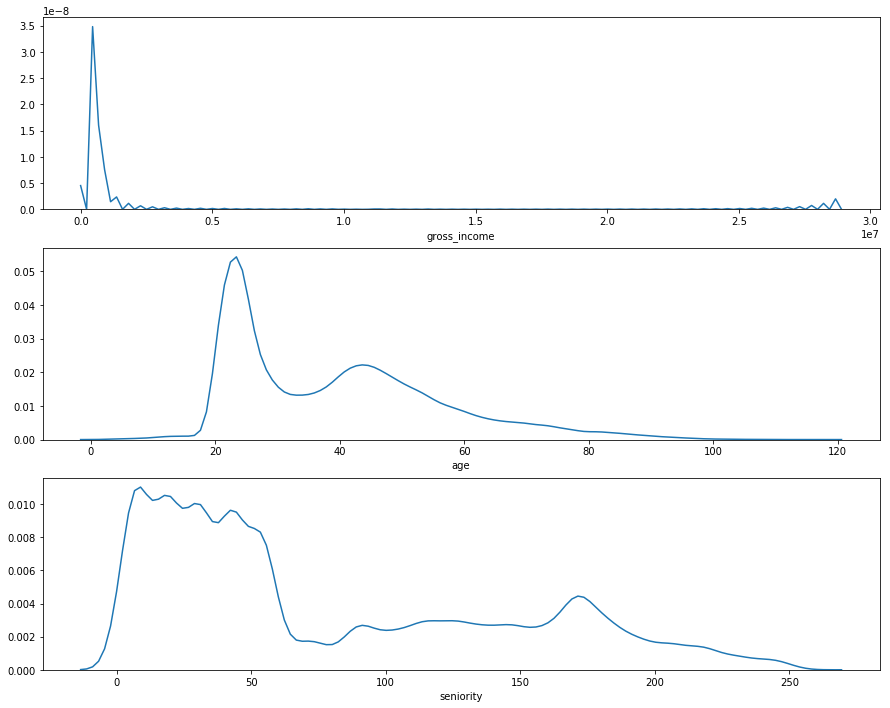

In [4]:
#Checking the distribution of continuous variables
f, axes = plt.subplots(3, 1,figsize=(15,12))
sns.distplot(One_but_last_month_data['gross_income'],hist=False,ax=axes[0])
sns.distplot(One_but_last_month_data['age'],hist=False,ax=axes[1])
sns.distplot(One_but_last_month_data['seniority'],hist=False,ax=axes[2])

In [5]:
#Subsetting data to perform segmentation and MBA
#1. Removing customers with less than 2 accounts
cluster_data = One_but_last_month_data
cluster_data = cluster_data[cluster_data['no_of_accounts'] > 1]

## K-Means Clustering

In [6]:
#Scale the continuous  variables to range (0,1)
scaler = MinMaxScaler()
cluster_data['gross_income_scaled']= scaler.fit_transform(cluster_data[['gross_income']])
cluster_data['seniority_scaled']= scaler.fit_transform(cluster_data[['seniority']])
cluster_data['age_scaled']= scaler.fit_transform(cluster_data[['age']])

#Using only continuous variables to perform Kmeans clustering
kmeans = KMeans(n_clusters=3,n_init=3, max_iter=3000, random_state=2019)
kmeans = kmeans.fit(cluster_data[['age_scaled', 'gross_income_scaled', 'seniority_scaled']])                                                       

In [7]:
#Storing the Kmeans results to cluster_data
cluster_data.loc[:,'Cluster_Segment'] = kmeans.labels_
#Check the cluser distribution
cluster_data['Cluster_Segment'].value_counts()/len(cluster_data)

0    0.375564
1    0.342870
2    0.281566
Name: Cluster_Segment, dtype: float64

In [8]:
#Subset the data based on clusters to perform MBA for each segment
seg1 = cluster_data[cluster_data['Cluster_Segment'] == 0]
seg2 = cluster_data[cluster_data['Cluster_Segment'] == 1]
seg3 = cluster_data[cluster_data['Cluster_Segment'] == 2]

## Exploring the Segment Distribution

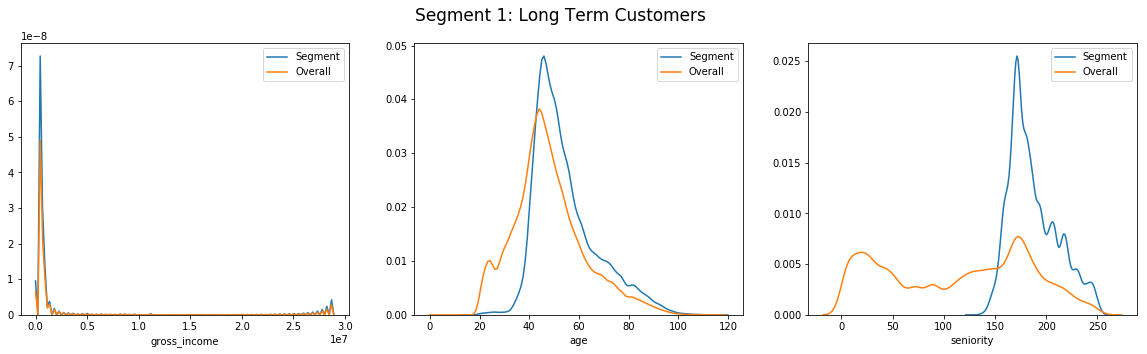

In [9]:
#Vairables distribution plot for segment1
f, axes = plt.subplots(1, 3,figsize=(20,5))
plt.suptitle('Segment 1: Long Term Customers', fontsize=17)
sns.distplot(seg1['gross_income'],hist=False,ax=axes[0], label = 'Segment')
sns.distplot(cluster_data['gross_income'],hist=False,ax=axes[0], label = 'Overall')
sns.distplot(seg1['age'],hist=False,ax=axes[1], label = 'Segment')
sns.distplot(cluster_data['age'],hist=False,ax=axes[1], label = 'Overall')
sns.distplot(seg1['seniority'],hist=False,ax=axes[2], label = 'Segment')
sns.distplot(cluster_data['seniority'],hist=False,ax=axes[2], label = 'Overall')

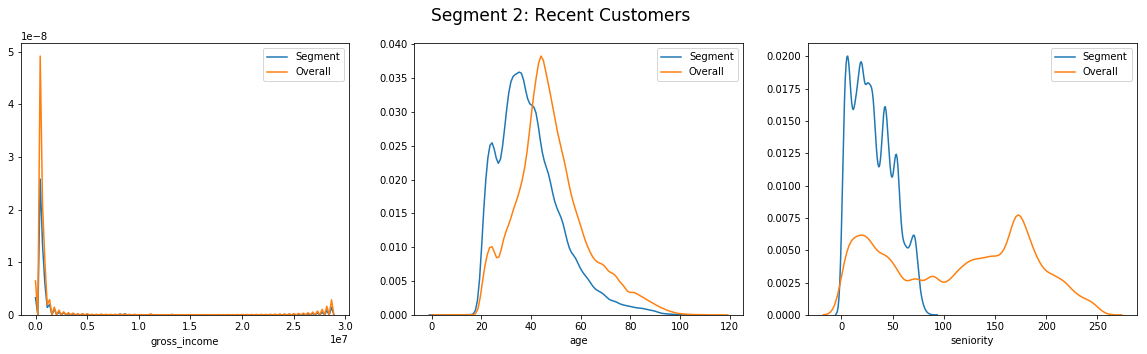

In [10]:
#Vairables distribution plot for segment2
f, axes = plt.subplots(1, 3,figsize=(20,5))
plt.suptitle('Segment 2: Recent Customers', fontsize=17)
sns.distplot(seg2['gross_income'],hist=False,ax=axes[0], label = 'Segment')
sns.distplot(cluster_data['gross_income'],hist=False,ax=axes[0], label = 'Overall')
sns.distplot(seg2['age'],hist=False,ax=axes[1], label = 'Segment')
sns.distplot(cluster_data['age'],hist=False,ax=axes[1], label = 'Overall')
sns.distplot(seg2['seniority'],hist=False,ax=axes[2], label = 'Segment')
sns.distplot(cluster_data['seniority'],hist=False,ax=axes[2], label = 'Overall')

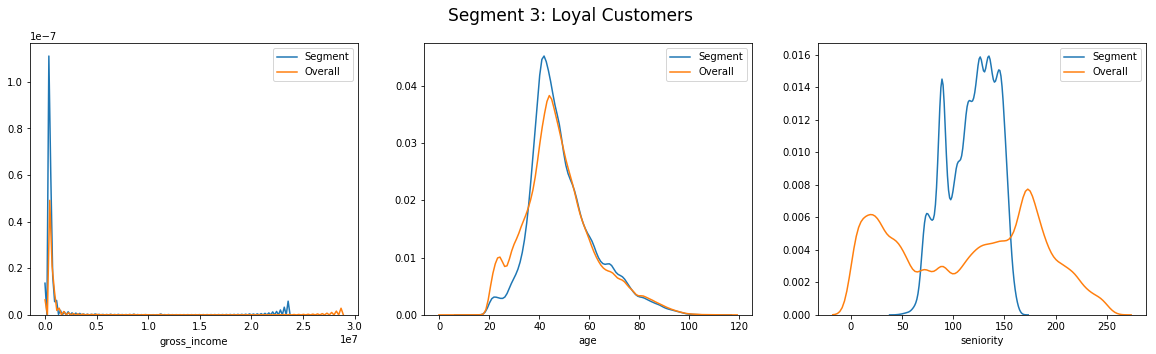

In [11]:
#Vairables distribution plot for segment3
f, axes = plt.subplots(1, 3,figsize=(20,5))
plt.suptitle('Segment 3: Loyal Customers', fontsize=17)
sns.distplot(seg3['gross_income'],hist=False,ax=axes[0], label = 'Segment')
sns.distplot(cluster_data['gross_income'],hist=False,ax=axes[0], label = 'Overall')
sns.distplot(seg3['age'],hist=False,ax=axes[1], label = 'Segment')
sns.distplot(cluster_data['age'],hist=False,ax=axes[1], label = 'Overall')
sns.distplot(seg3['seniority'],hist=False,ax=axes[2], label = 'Segment')
sns.distplot(cluster_data['seniority'],hist=False,ax=axes[2], label = 'Overall')

## Market Basket Analysis

### 1. Creating transactions data for each segment

In [12]:
#Extracting the products columns to perform MBA
list_columns = list(One_but_last_month_data)
list_accounts = list_columns[11:33]
list_accounts.append('customer_code')

In [13]:
#Function to create transaction data for each segment
def maketrans(transactions):
    transactions_filter = transactions[list_accounts]
    transactions_filter=transactions_filter.set_index('customer_code')
    return transactions_filter

In [14]:
#Create transactions data from each segment
seg1_trans = maketrans(seg1)
seg2_trans = maketrans(seg2)
seg3_trans = maketrans(seg3)

In [15]:
#Exploring the transaction data
seg1_trans.head()

,ind_savings_account,ind_guarantees,ind_current_account,ind_derivada_account,ind_payroll_account,ind_junior_account,ind_mas_particular_account,ind_particular_account,ind_particular_plus_account,ind_short_term_deposit,...,ind_eaccount,ind_funds,ind_mortgage,ind_loans,ind_taxes,ind_credit_cards,ind_securities,ind_home_accounts,ind_pensions_2,ind_direct_debits
customer_code,,,,,,,,,,,,,,,,,,,,,
265720,0,0,1,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
660237,0,0,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1
644465,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
519429,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
518316,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2. Generating association rules for each segment

In [16]:
#MBA for segment 1
frequent_itemsets_seg1 = apriori(seg1_trans, min_support=0.02, use_colnames=True)
frequent_itemsets_seg1 = frequent_itemsets_seg1[frequent_itemsets_seg1.itemsets.map(len)<4]
rules_seg1 = association_rules(frequent_itemsets_seg1, metric="lift", min_threshold=2)
rules_seg1.sort_values(by=['lift'],ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
147,"(ind_payroll_account, ind_credit_cards)",(ind_pensions_2),0.114654,0.209309,0.091065,0.794260,3.794682,0.067067,3.843162
150,(ind_pensions_2),"(ind_payroll_account, ind_credit_cards)",0.209309,0.114654,0.091065,0.435074,3.794682,0.067067,1.567189
64,"(ind_payroll_account, ind_particular_plus_acco...",(ind_pensions_2),0.068410,0.209309,0.053592,0.783393,3.742762,0.039273,3.650348
69,(ind_pensions_2),"(ind_payroll_account, ind_particular_plus_acco...",0.209309,0.068410,0.053592,0.256041,3.742762,0.039273,1.252207
167,"(ind_payroll_account, ind_direct_debits)",(ind_pensions_2),0.220948,0.209309,0.170580,0.772037,3.688506,0.124333,3.468501
170,(ind_pensions_2),"(ind_payroll_account, ind_direct_debits)",0.209309,0.220948,0.170580,0.814966,3.688506,0.124333,4.210327
98,"(ind_payroll_account, ind_eaccount)",(ind_pensions_2),0.134307,0.209309,0.102314,0.761794,3.639572,0.074203,3.319365
101,(ind_pensions_2),"(ind_payroll_account, ind_eaccount)",0.209309,0.134307,0.102314,0.488820,3.639572,0.074203,1.693520
66,"(ind_particular_plus_account, ind_pensions_2)",(ind_payroll_account),0.056504,0.261077,0.053592,0.948456,3.632852,0.038840,14.335663
67,(ind_payroll_account),"(ind_particular_plus_account, ind_pensions_2)",0.261077,0.056504,0.053592,0.205271,3.632852,0.038840,1.187192


In [17]:
#MBA for segment 2
frequent_itemsets_seg2 = apriori(seg2_trans, min_support=0.02, use_colnames=True)
frequent_itemsets_seg2 = frequent_itemsets_seg2[frequent_itemsets_seg2.itemsets.map(len)<4]
rules_seg2 = association_rules(frequent_itemsets_seg2, metric="lift", min_threshold=1)
rules_seg2.sort_values(by=['lift'],ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
35,"(ind_payroll_account, ind_eaccount)",(ind_credit_cards),0.084540,0.082165,0.020882,0.247011,3.006269,0.013936,1.218922
38,(ind_credit_cards),"(ind_payroll_account, ind_eaccount)",0.082165,0.084540,0.020882,0.254149,3.006269,0.013936,1.227404
64,(ind_pensions_2),"(ind_payroll_account, ind_credit_cards)",0.245595,0.048011,0.034544,0.140654,2.929629,0.022753,1.107807
61,"(ind_payroll_account, ind_credit_cards)",(ind_pensions_2),0.048011,0.245595,0.034544,0.719503,2.929629,0.022753,2.689528
74,"(ind_pensions_2, ind_direct_debits)",(ind_payroll_account),0.162139,0.325082,0.154078,0.950285,2.923218,0.101370,13.575845
75,(ind_payroll_account),"(ind_pensions_2, ind_direct_debits)",0.325082,0.162139,0.154078,0.473968,2.923218,0.101370,1.592795
63,(ind_payroll_account),"(ind_pensions_2, ind_credit_cards)",0.325082,0.036663,0.034544,0.106263,2.898383,0.022626,1.077875
62,"(ind_pensions_2, ind_credit_cards)",(ind_payroll_account),0.036663,0.325082,0.034544,0.942212,2.898383,0.022626,11.679186
13,(ind_pensions_2),(ind_payroll_account),0.245595,0.325082,0.230923,0.940258,2.892372,0.151084,11.297177
12,(ind_payroll_account),(ind_pensions_2),0.325082,0.245595,0.230923,0.710353,2.892372,0.151084,2.604565


In [18]:
#MBA for segment 3
frequent_itemsets_seg3 = apriori(seg3_trans, min_support=0.02, use_colnames=True)
frequent_itemsets_seg3 = frequent_itemsets_seg3[frequent_itemsets_seg3.itemsets.map(len)<4]
rules_seg3 = association_rules(frequent_itemsets_seg3, metric="lift", min_threshold=2)
rules_seg3.sort_values(by=['lift'],ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
75,"(ind_payroll_account, ind_credit_cards)",(ind_pensions_2),0.081209,0.169313,0.059888,0.737448,4.355519,0.046138,3.163888
78,(ind_pensions_2),"(ind_payroll_account, ind_credit_cards)",0.169313,0.081209,0.059888,0.353709,4.355519,0.046138,1.421636
87,"(ind_payroll_account, ind_direct_debits)",(ind_pensions_2),0.181798,0.169313,0.130822,0.719599,4.250100,0.100041,2.962492
90,(ind_pensions_2),"(ind_payroll_account, ind_direct_debits)",0.169313,0.181798,0.130822,0.772660,4.250100,0.100041,3.599017
35,(ind_pensions_2),"(ind_payroll_account, ind_particular_plus_acco...",0.169313,0.056374,0.040108,0.236886,4.202077,0.030563,1.236547
32,"(ind_payroll_account, ind_particular_plus_acco...",(ind_pensions_2),0.056374,0.169313,0.040108,0.711468,4.202077,0.030563,2.879007
51,(ind_pensions_2),"(ind_payroll_account, ind_eaccount)",0.169313,0.098394,0.069570,0.410894,4.175999,0.052910,1.530465
48,"(ind_payroll_account, ind_eaccount)",(ind_pensions_2),0.098394,0.169313,0.069570,0.707052,4.175999,0.052910,2.835616
67,(ind_pensions_2),"(ind_payroll_account, ind_taxes)",0.169313,0.089216,0.062601,0.369735,4.144260,0.047496,1.445080
62,"(ind_payroll_account, ind_taxes)",(ind_pensions_2),0.089216,0.169313,0.062601,0.701679,4.144260,0.047496,2.784536


### 3. Chi-square test for association rules in each segment

In [19]:
#Chi-square test for segment 1 associations rules
rules_seg1['chisq'] = ''
rules_seg1['pvalue'] = ''
for i in range(0,len(rules_seg1)):
    if not ((rules_seg1['support'][i] == rules_seg1['confidence'][i]) or (rules_seg1['lift'][i] == rules_seg1['confidence'][i])):
        a=len(seg1)
        b=(rules_seg1['lift'][i]-1)**2
        c=(rules_seg1['support'][i])*(rules_seg1['confidence'][i])
        d=(rules_seg1['confidence'][i] - rules_seg1['support'][i])
        e=(rules_seg1['lift'][i]-rules_seg1['confidence'][i])
        rules_seg1['chisq'][i] = ((a*b*c)/(d*e))
        rules_seg1['pvalue'][i] = 1-(stats.chi2.cdf(rules_seg1['chisq'][i], 1))      

#Removing insignificant rules based on pvalue
rules_seg1 = rules_seg1[rules_seg1['pvalue'] < 0.05]
rules_seg1.sort_values(by=['lift', 'confidence'], ascending = False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,chisq,pvalue
147,"(ind_payroll_account, ind_credit_cards)",(ind_pensions_2),0.114654,0.209309,0.091065,0.794260,3.794682,0.067067,3.843162,24085.7,0
150,(ind_pensions_2),"(ind_payroll_account, ind_credit_cards)",0.209309,0.114654,0.091065,0.435074,3.794682,0.067067,1.567189,24085.7,0
64,"(ind_payroll_account, ind_particular_plus_acco...",(ind_pensions_2),0.068410,0.209309,0.053592,0.783393,3.742762,0.039273,3.650348,13155,0
69,(ind_pensions_2),"(ind_payroll_account, ind_particular_plus_acco...",0.209309,0.068410,0.053592,0.256041,3.742762,0.039273,1.252207,13155,0
170,(ind_pensions_2),"(ind_payroll_account, ind_direct_debits)",0.209309,0.220948,0.170580,0.814966,3.688506,0.124333,4.210327,48816.3,0
167,"(ind_payroll_account, ind_direct_debits)",(ind_pensions_2),0.220948,0.209309,0.170580,0.772037,3.688506,0.124333,3.468501,48816.3,0
98,"(ind_payroll_account, ind_eaccount)",(ind_pensions_2),0.134307,0.209309,0.102314,0.761794,3.639572,0.074203,3.319365,25740.8,0
101,(ind_pensions_2),"(ind_payroll_account, ind_eaccount)",0.209309,0.134307,0.102314,0.488820,3.639572,0.074203,1.693520,25740.8,0
66,"(ind_particular_plus_account, ind_pensions_2)",(ind_payroll_account),0.056504,0.261077,0.053592,0.948456,3.632852,0.038840,14.335663,13194.8,0
67,(ind_payroll_account),"(ind_particular_plus_account, ind_pensions_2)",0.261077,0.056504,0.053592,0.205271,3.632852,0.038840,1.187192,13194.8,0


#### There are three types particular accounts ( Mas Particular, Particular and Particular Plus) depending on the level of commitment of the customer with the bank.

#### For the long term customers who has been with the bank for more than 12 years, we can see that they are likely to hold a particular plus account along with credit card account and payroll account

In [20]:
#Chi-square test for segment 2 associations rules
rules_seg2['chisq'] = ''
rules_seg2['pvalue'] = ''
for i in range(0,len(rules_seg2)):
    if not ((rules_seg2['support'][i] == rules_seg2['confidence'][i]) or (rules_seg2['lift'][i] == rules_seg2['confidence'][i])):
        a=len(seg2)
        b=(rules_seg2['lift'][i]-1)**2
        c=(rules_seg2['support'][i])*(rules_seg2['confidence'][i])
        d=(rules_seg2['confidence'][i] - rules_seg2['support'][i])
        e=(rules_seg2['lift'][i]-rules_seg2['confidence'][i])
        rules_seg2['chisq'][i] = ((a*b*c)/(d*e))
        rules_seg2['pvalue'][i] = 1-(stats.chi2.cdf(rules_seg2['chisq'][i], 1)) 

#Removing insignificant rules based on pvalue
rules_seg2 = rules_seg2[rules_seg2['pvalue'] < 0.05]
rules_seg2.sort_values(by=['lift', 'confidence'], ascending = False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,chisq,pvalue
38,(ind_credit_cards),"(ind_payroll_account, ind_eaccount)",0.082165,0.084540,0.020882,0.254149,3.006269,0.013936,1.227404,2732.82,0
35,"(ind_payroll_account, ind_eaccount)",(ind_credit_cards),0.084540,0.082165,0.020882,0.247011,3.006269,0.013936,1.218922,2732.82,0
61,"(ind_payroll_account, ind_credit_cards)",(ind_pensions_2),0.048011,0.245595,0.034544,0.719503,2.929629,0.022753,2.689528,5020.63,0
64,(ind_pensions_2),"(ind_payroll_account, ind_credit_cards)",0.245595,0.048011,0.034544,0.140654,2.929629,0.022753,1.107807,5020.63,0
74,"(ind_pensions_2, ind_direct_debits)",(ind_payroll_account),0.162139,0.325082,0.154078,0.950285,2.923218,0.101370,13.575845,28314,0
75,(ind_payroll_account),"(ind_pensions_2, ind_direct_debits)",0.325082,0.162139,0.154078,0.473968,2.923218,0.101370,1.592795,28314,0
62,"(ind_pensions_2, ind_credit_cards)",(ind_payroll_account),0.036663,0.325082,0.034544,0.942212,2.898383,0.022626,11.679186,5425.53,0
63,(ind_payroll_account),"(ind_pensions_2, ind_credit_cards)",0.325082,0.036663,0.034544,0.106263,2.898383,0.022626,1.077875,5425.53,0
13,(ind_pensions_2),(ind_payroll_account),0.245595,0.325082,0.230923,0.940258,2.892372,0.151084,11.297177,46116.5,0
12,(ind_payroll_account),(ind_pensions_2),0.325082,0.245595,0.230923,0.710353,2.892372,0.151084,2.604565,46116.5,0


#### For the most recent customers who has been with the bank for around 3-7 years, we can see that they are likely to hold a Mas Particular Account and E-Account along with payroll account and credit card account

In [21]:
#Chi-square test for segment 3 associations rules
rules_seg3['chisq'] = ''
rules_seg3['pvalue'] = ''
for i in range(0,len(rules_seg3)):
    if not ((rules_seg3['support'][i] == rules_seg3['confidence'][i]) or (rules_seg3['lift'][i] == rules_seg3['confidence'][i])):
        a=len(seg3)
        b=(rules_seg3['lift'][i]-1)**2
        c=(rules_seg3['support'][i])*(rules_seg3['confidence'][i])
        d=(rules_seg3['confidence'][i] - rules_seg3['support'][i])
        e=(rules_seg3['lift'][i]-rules_seg3['confidence'][i])
        rules_seg3['chisq'][i] = ((a*b*c)/(d*e))
        rules_seg3['pvalue'][i] = 1-(stats.chi2.cdf(rules_seg3['chisq'][i], 1))   
        
#Removing insignificant rules based on pvalue
rules_seg3 = rules_seg3[rules_seg3['pvalue'] < 0.05]
rules_seg3.sort_values(by=['lift', 'confidence'], ascending = False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,chisq,pvalue
75,"(ind_payroll_account, ind_credit_cards)",(ind_pensions_2),0.081209,0.169313,0.059888,0.737448,4.355519,0.046138,3.163888,13680.4,0
78,(ind_pensions_2),"(ind_payroll_account, ind_credit_cards)",0.169313,0.081209,0.059888,0.353709,4.355519,0.046138,1.421636,13680.4,0
90,(ind_pensions_2),"(ind_payroll_account, ind_direct_debits)",0.169313,0.181798,0.130822,0.772660,4.250100,0.100041,3.599017,32263.6,0
87,"(ind_payroll_account, ind_direct_debits)",(ind_pensions_2),0.181798,0.169313,0.130822,0.719599,4.250100,0.100041,2.962492,32263.6,0
32,"(ind_payroll_account, ind_particular_plus_acco...",(ind_pensions_2),0.056374,0.169313,0.040108,0.711468,4.202077,0.030563,2.879007,8420.34,0
35,(ind_pensions_2),"(ind_payroll_account, ind_particular_plus_acco...",0.169313,0.056374,0.040108,0.236886,4.202077,0.030563,1.236547,8420.34,0
51,(ind_pensions_2),"(ind_payroll_account, ind_eaccount)",0.169313,0.098394,0.069570,0.410894,4.175999,0.052910,1.530465,15132.3,0
48,"(ind_payroll_account, ind_eaccount)",(ind_pensions_2),0.098394,0.169313,0.069570,0.707052,4.175999,0.052910,2.835616,15132.3,0
62,"(ind_payroll_account, ind_taxes)",(ind_pensions_2),0.089216,0.169313,0.062601,0.701679,4.144260,0.047496,2.784536,13312.4,0
67,(ind_pensions_2),"(ind_payroll_account, ind_taxes)",0.169313,0.089216,0.062601,0.369735,4.144260,0.047496,1.445080,13312.4,0


#### For the loyal customer who has been with the bank for around 7-12 years, they are likely to hold Taxes account, Particular_Plus and also Particular Account along with Credit card account and Payroll account 

## Most popular accounts by segment

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]), <a list of 22 Text xticklabel objects>)

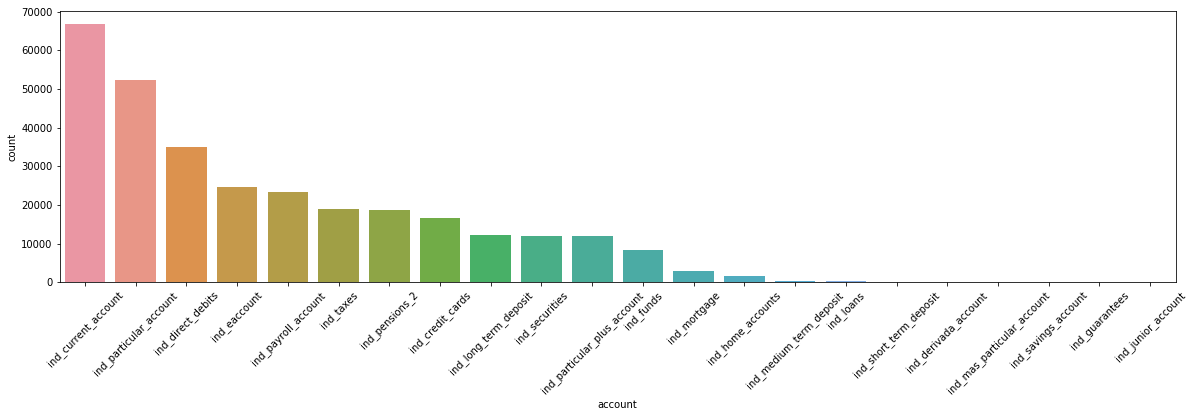

In [22]:
#Countplot to view the most popular produts in segment 1
seg1_trans_stack=seg1_trans.stack().to_frame().reset_index()
seg1_trans_stack.columns=['customer_code','account','indicator']
seg1_trans_stack=seg1_trans_stack[seg1_trans_stack.indicator == 1]
plt.figure(figsize=(20,5))
sns.countplot(seg1_trans_stack['account'],order=seg1_trans_stack['account'].value_counts().index)
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]), <a list of 21 Text xticklabel objects>)

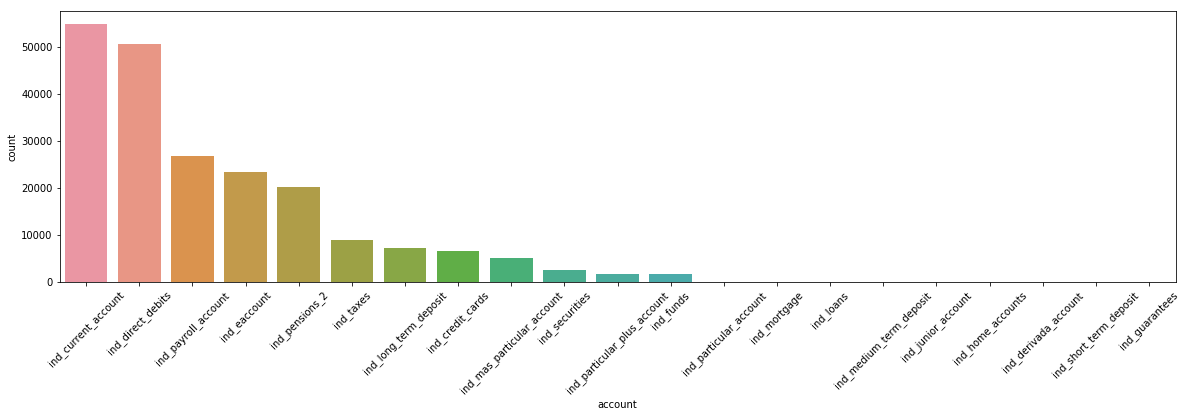

In [23]:
#Countplot to view the most popular produts in segment 2
seg2_trans_stack=seg2_trans.stack().to_frame().reset_index()
seg2_trans_stack.columns=['customer_code','account','indicator']
seg2_trans_stack=seg2_trans_stack[seg2_trans_stack.indicator == 1]
plt.figure(figsize=(20,5))
sns.countplot(seg2_trans_stack['account'],order=seg2_trans_stack['account'].value_counts().index)
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]), <a list of 22 Text xticklabel objects>)

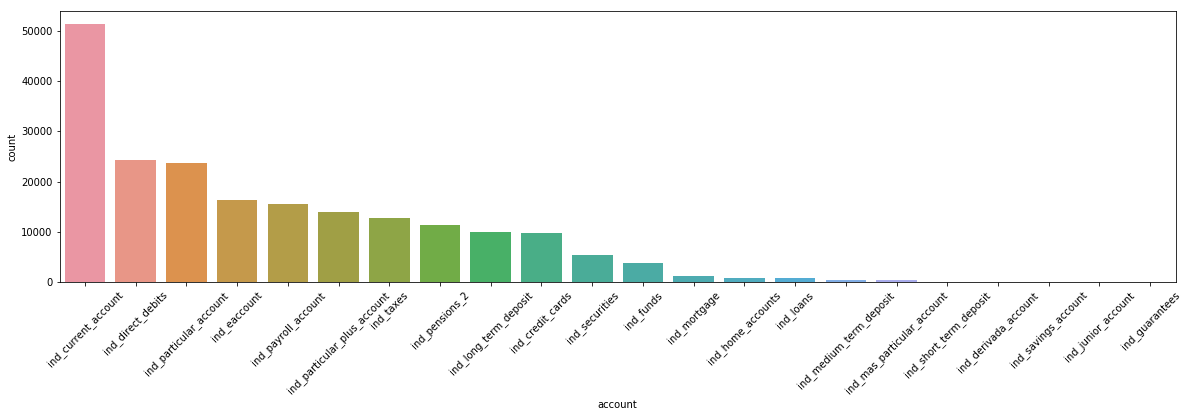

In [24]:
#Countplot to view the most popular produts in segment 3
seg3_trans_stack=seg3_trans.stack().to_frame().reset_index()
seg3_trans_stack.columns=['customer_code','account','indicator']
seg3_trans_stack=seg3_trans_stack[seg3_trans_stack.indicator == 1]
plt.figure(figsize=(20,5))
sns.countplot(seg3_trans_stack['account'],order=seg3_trans_stack['account'].value_counts().index)
plt.xticks(rotation=45)